In [44]:
import warnings

# To suppress all warnings
warnings.filterwarnings('ignore')

In [45]:
import geopandas as gpd
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
import json
import ipywidgets as widgets

In [46]:
# Read the data
dc_wards = gpd.read_file("neighbourhoods.geojson")
dc_wards.head()

,neighbourhood,neighbourhood_group,geometry
0,"Congress Heights, Bellevue, Washington Highlands",None,"MULTIPOLYGON (((-77.01389 38.82865, -77.01386 ..."
1,"Douglas, Shipley Terrace",None,"MULTIPOLYGON (((-76.99291 38.85391, -76.99231 ..."
2,"Woodland/Fort Stanton, Garfield Heights, Knox ...",None,"MULTIPOLYGON (((-76.97714 38.85728, -76.97721 ..."
3,"Near Southeast, Navy Yard",None,"MULTIPOLYGON (((-76.97936 38.87756, -76.97937 ..."
4,"River Terrace, Benning, Greenway, Dupont Park",None,"MULTIPOLYGON (((-76.93760 38.88996, -76.93752 ..."


In [47]:
geojson_dict = json.loads(dc_wards.to_json())
geojson_dict['features'][0]['properties']

{'neighbourhood': 'Congress Heights, Bellevue, Washington Highlands',
 'neighbourhood_group': None}

In [52]:
df = pd.read_csv("cleaned_data.csv")
pd.set_option('display.max_columns', None)

Q1 = df['price_num'].quantile(0.25)
Q3 = df['price_num'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['price_num'] <= upper_bound) & (df['price_num'] >= lower_bound)]

df.head()

,host_name,host_since,host_location,host_about,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price_num,taken_30,taken_60,sales_30,sales_60,host_days_since,host_desc_len
0,Vita,2008-11-26,"Washington D.C., DC","I am a literary scholar, teacher, poet, vegan ...",NaN,100%,t,Anacostia,1,4,"['email', 'phone', 'work_email']",t,t,"Washington, District of Columbia, United States",Historic Anacostia,38.86339,-76.98889,Private room in home,Private room,1,NaN,1 private bath,NaN,1.0,[],$67.00,31,365,NaN,t,30,60,90,365,2023-12-18,84,3,0,2010-11-01,2023-08-30,4.64,4.73,4.45,4.91,4.84,3.91,4.64,NaN,f,1,0,1,0,0.53,67.0,0,0,0.0,0.0,5608,1028
1,Vasa,2008-12-12,"Washington, DC",I travel often and always try to immerse mysel...,100%,97%,t,Eckington,5,5,"['email', 'phone']",t,t,"Washington, District of Columbia, United States","Edgewood, Bloomingdale, Truxton Circle, Eckington",38.91195,-77.00456,Private room in townhouse,Private room,2,NaN,1 private bath,NaN,1.0,[],$66.00,1,1125,NaN,t,8,11,11,252,2023-12-18,495,46,2,2009-05-10,2023-11-22,4.83,4.88,4.92,4.94,4.91,4.57,4.75,Hosted License: 5007242201001033,f,5,0,5,0,2.78,66.0,22,49,1452.0,3234.0,5592,445
2,Sandra,2008-12-12,"Washington D.C., DC",I’m a California native who came to work for t...,100%,100%,t,Capitol Hill,2,2,"['email', 'phone']",t,t,"Washington, District of Columbia, United States","Capitol Hill, Lincoln Park",38.88719,-76.99472,Private room in home,Private room,1,NaN,1.5 shared baths,NaN,1.0,[],$135.00,7,1125,NaN,t,6,21,51,321,2023-12-18,58,6,0,2009-05-14,2023-11-11,4.85,4.98,4.87,5.00,4.98,4.96,4.95,Hosted License: 5007242201000749,f,2,0,2,0,0.33,135.0,24,39,3240.0,5265.0,5592,239
3,Bertina,2008-12-30,"Washington, DC",I am a retried teacher. I enjoy walking and wa...,NaN,NaN,f,Eastland Gardens,4,4,"['email', 'phone']",t,t,"Washington, District of Columbia, United States","Eastland Gardens, Kenilworth",38.90585,-76.94469,Private room in home,Private room,2,NaN,1 shared bath,NaN,1.0,[],$56.00,30,1125,NaN,t,29,59,89,179,2023-12-18,102,0,0,2009-08-08,2019-07-05,4.66,4.80,4.60,4.93,4.93,4.51,4.83,Exempt,f,2,0,2,0,0.58,56.0,1,1,56.0,56.0,5574,62
5,Ami,2009-01-13,"Washington D.C., DC","I am an environmentalist, and I own and operat...",NaN,33%,f,Adams Morgan,2,4,"['email', 'phone', 'work_email']",t,t,"Washington, District of Columbia, United States","Kalorama Heights, Adams Morgan, Lanier Heights",38.91887,-77.04008,Entire rental unit,Entire home/apt,3,NaN,1 bath,NaN,1.0,[],$60.00,31,45,NaN,t,0,1,31,121,2023-12-18,96,1,0,2009-09-22,2023-08-17,4.50,4.71,4.13,4.82,4.82,4.91,4.44,NaN,f,1,1,0,0,0.55,60.0,30,59,1800.0,3540.0,5560,456


In [57]:
# get average rating
specified_review_score_columns = [
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
    'review_scores_value'
]

# Calculate the average review score across the specified columns
df['median_review_score'] = df[specified_review_score_columns].median(axis=1)

# create a new data frame
review_score_df = df.groupby('neighbourhood_cleansed').agg({
    'price_num': 'median',
    'median_review_score':'median'
}).reset_index()

In [50]:
dc_wards['neighbourhood_cleansed'] = dc_wards['neighbourhood']
merged_gdf = dc_wards.merge(df, on='neighbourhood_cleansed', how='right')

In [58]:
top_5_list = df['neighbourhood_cleansed'].value_counts().head(5).keys()

In [59]:
top_5_list

Index(['Union Station, Stanton Park, Kingman Park',
       'Capitol Hill, Lincoln Park',
       'Edgewood, Bloomingdale, Truxton Circle, Eckington',
       'Columbia Heights, Mt. Pleasant, Pleasant Plains, Park View',
       'Dupont Circle, Connecticut Avenue/K Street'],
      dtype='object', name='neighbourhood_cleansed')

In [82]:
df['bathroom_num'] = df['bathrooms_text'].str.extract(r'(\d+)', expand=False)
df['bathroom_num'] = pd.to_numeric(df['bathroom_num'])

fig=px.box(df, x='bathroom_num',y='price_num')
fig.update_xaxes(title_text='Number of Bathroom')
fig.update_yaxes(title_text='Price')
fig.update_layout(title='Price of Airbnbs by the Number of Bathrooms')
fig.show()

In [83]:
fig = px.box(df, x='accommodates',y='price_num')
fig.update_xaxes(title_text='Number of Accommodates Possible')
fig.update_yaxes(title_text='Price')
fig.update_layout(title='Price of Airbnbs by the Number of Accommodates')
fig.show()

In [62]:
import math

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a)) 
    # Radius of earth in miles
    radius = 3956
    distance = radius * c
    return distance

# Target point (e.g., New York City)
target_latitude = 38.8895
target_longitude = -77.0353


# Calculate distance from target point to each point in the DataFrame
df['Distance_miles'] = df.apply(lambda row: haversine(row['longitude'], row['latitude'], target_longitude, target_latitude), axis=1)


In [79]:
# Create an interactive scatter plot with tooltips
fig = px.scatter(df, x='Distance_miles', y='price_num', color='neighbourhood_cleansed', 
                 hover_data={'Distance_miles': True, 'price_num': True, 'neighbourhood_cleansed': True})

# Update layout to customize the tooltip display
fig.update_traces(marker=dict(size=3),
                  selector=dict(mode='markers'))
fig.update_xaxes(title_text='Distance from the National Monument (Miles)')
fig.update_yaxes(title_text='Price')
fig.update_layout(title='Price of Airbnbs by How Far the Airbnbs are from the National Monument')
fig.show()

# Show the plot
fig.show()


In [64]:
# Create a subset DataFrame containing only the top 5 neighbourhoods
df_top_5 = df[df['neighbourhood_cleansed'].isin(top_5_list)]

# Calculate the linear trend line using the overall data
X = df_top_5['Distance_miles']
y = df_top_5['price_num']
X = sm.add_constant(X)  # Add a constant term to the predictor
model = sm.OLS(y, X).fit()
trendline = model.predict(X)

# Create a scatter plot with the top 5 neighbourhoods
fig = px.scatter(df_top_5, x='Distance_miles', y='price_num', color='neighbourhood_cleansed')

# Add the trendline to the plot
fig.add_trace(px.line(x=df_top_5['Distance_miles'], y=trendline, title='Overall Trend').data[0])

# Update layout to set the y-axis range
fig.update_layout(title='Neighbourhood')  # Set the y-axis range as needed

# Show the plot
fig.show()


In [71]:
for i in top_5_list:
    df_i = df[df['neighbourhood_cleansed'] == i]
    fig = px.box(df_i, x='bathroom_num', y='price_num')
    fig.update_layout(title=i)
    fig.update_xaxes(title_text='Number of Bathrooms')
    fig.update_yaxes(title_text='Price')
    fig.show()

In [72]:
for i in top_5_list:
    df_i = df[df['neighbourhood_cleansed']==i]
    fig = px.scatter(df_i, x='host_days_since',y='price_num')
    fig.update_layout(title=i)
    fig.update_xaxes(title_text='Number of Days Hosting')
    fig.update_yaxes(title_text='Price')
    fig.show()

In [21]:
df_price = df.groupby("neighbourhood_cleansed")[["price_num"]].median().reset_index()

<Axes: xlabel='price_num', ylabel='Count'>

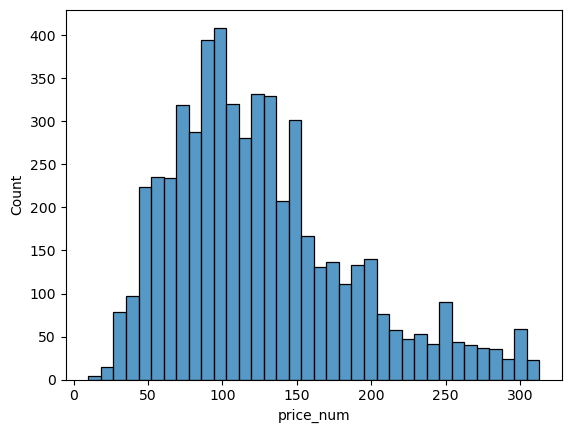

In [78]:
import seaborn as sns
sns.histplot(df, x='price_num')

In [ ]:
df_reviews = df.groupby(["neighbourhood_abb"])[['review_scores_rating', 'review_scores_communication', 
                                                'review_scores_checkin', 'review_scores_cleanliness', 'review_scores_location', 
                                                'review_scores_value']].median().reset_index()

In [ ]:
columns = ['availability_365', 'number_of_reviews', 'taken_30', 'sales_30', 'reviews_per_month', 'host_days_since']
for i in columns:
    sns.histplot(df, x=i)
    plt.title(i)
    plt.show()

In [ ]:
neighbourhood_taken_60_sum = df.groupby('neighbourhood_cleansed')['taken_60'].sum().sort_values(ascending=False)

top_ten_neighbourhoods = neighbourhood_taken_60_sum.head(10)
names_only = top_ten_neighbourhoods.index
top_neighbourhoods = list(names_only)
df_withtop_10 = df[df['neighbourhood_cleansed'].isin(top_neighbourhoods)]

In [ ]:
# Grouping data by 'neighbourhood_cleansed' and calculating mean for price, latitude, and longitude
data_for_pop = df_withtop_10.groupby('neighbourhood_cleansed').agg({
    'price_num': 'median',
    'latitude': 'mean',
    'longitude': 'mean'
}).reset_index()

In [ ]:
dc_wards = gpd.read_file("data/ACS_Demographic_Characteristics_DC_Ward.geojson")[
    ["NAMELSAD", "DP05_0001E", "geometry"]
]

In [ ]:
import pandas as pd
import folium
import json
from folium import Icon


dc_wards['Population_Density'] = dc_wards['DP05_0001E'] / dc_wards.geometry.area
m = folium.Map(location=[38.9072, -77.0369], zoom_start=12, tiles='cartodbpositron')  # Changed tiles here

choropleth = folium.Choropleth(
    geo_data=dc_wards,
    data=dc_wards,
    columns=['NAMELSAD', 'Population_Density'],
    key_on='feature.properties.NAMELSAD',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Population Density in DC'
).add_to(m)

neighbourhood_data = df_withtop_10.groupby('neighbourhood_cleansed').agg({
    'price_num': 'median',
    'average_review_score':'median',
    'latitude': 'mean',
    'longitude': 'mean'
}).reset_index()


for index, row in neighbourhood_data.iterrows():
    popup_html = f"""
    <div style="width:200px;">
        <strong>{row['neighbourhood_cleansed']}</strong><br>
        Median price: ${round(row['price_num'], 2)}<br>
        Median rating: {round(row['median_review_score'], 2)}
    </div>
    """
    folium.Marker(
        [row['latitude'], row['longitude']],
        popup=folium.Popup(popup_html, max_width=265),
        tooltip=row['neighbourhood_cleansed'],
        icon=Icon(color='blue', icon='info-sign')
    ).add_to(m)

# Display the map
m

In [ ]:
import pandas as pd
import plotly.graph_objects as go


fig = px.choropleth_mapbox(
    merged_gdf,
    geojson=geojson_dict,
    locations='neighbourhood_cleansed',  
    featureidkey='properties.neighbourhood_cleansed',  
    color='price_num',  
    color_continuous_scale="tealrose",  
    mapbox_style="carto-positron",  
    zoom=10,  
    center={"lat": 38.9, "lon": -77.03}, 
    opacity=0.5,  
    labels={'neighbourhood_cleansed':'Area','price_num': 'Median Price',}, 
    hover_data={
        'neighbourhood_cleansed': True,
        'price_num': ':.2f',  
    }
)
fig.update_traces(
    hovertemplate=(
        "<b>%{customdata[0]}</b><br>"
        "<span style='font-size:0.9em;'>Median Price:</span> "
        "<span style='font-size:0.9em;'><b>$%{customdata[1]:.2f}</b></span><br>"
    )
)

fig.add_trace(
    go.Scattermapbox(
        lat=neighbourhood_data['latitude'],
        lon=neighbourhood_data['longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=9,
            color='black',
            opacity=0.7
        ),
        text=neighbourhood_data.apply(lambda row: f"{row['neighbourhood_cleansed']}<br>Median Price: ${round(row['price_num'], 2)}", axis=1),
        hoverinfo='text'
    )
    
)

fig.update_layout(
    hoverlabel=dict(
        font=dict(family="Courier New, monospace", size=12),
        bordercolor='pink',
        bgcolor='white'
    ),
    title='Median Airbnb Price and Review by Neighborhood in DC',
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
    clickmode='event+select'
)

fig.show()

In [ ]:
import pandas as pd
import numpy as np
# !pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
from nltk.corpus import stopwords
import nltk


host_about_text = df['host_about'].dropna()
combined_text = " ".join(host_about_text)

# Removing punctuation
translator = str.maketrans('', '', string.punctuation)
text_no_punctuation = combined_text.translate(translator)
nltk.download('stopwords')

# Set of English stopwords
stop_words = set(stopwords.words('english'))

# Remove basic stopwords
text_no_basic_stopwords = ' '.join([word for word in text_no_punctuation.lower().split() if word not in stop_words])
mask = np.array(Image.open("comment.png"))
# Generate the word cloud with the simplified stopword set
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10,mask=mask).generate(text_no_basic_stopwords)

# Display the word cloud
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

In [ ]:
bins = [0, 50, 100, 150, 200, 250, 300]
labels = ['0-50', '50-100', '100-150', '150-200', '200-250', '250-300']
df['price_range'] = pd.cut(df['price_num'], bins=bins, labels=labels, right=False)

average_rating_by_price_range = df.groupby('price_range')['average_review_score'].mean().reset_index()

def plot_relation(metric):
    plt.figure(figsize=(12, 8))
    if metric == 'Relationship between Price and Average Review Score':
        sns.regplot(x='price_num', y='average_review_score', data=df, scatter_kws={'alpha':0.5},color="pink", line_kws={'color': 'lightblue'})
        plt.title('Relationship between Price and Average Review Score (Without Outliers)',fontsize=18)
        plt.xlabel('Price ($)',fontsize=14)
        plt.ylabel('Average Review Score',fontsize=14)
    else:
        sns.barplot(x='price_range', y='average_review_score', data=average_rating_by_price_range, palette='viridis')
        plt.title('Average Review Score by Price Range',fontsize=18)
        plt.xlabel('Price Range ($)',fontsize=14)
        plt.ylabel('Average Review Score',fontsize=14)
    
    plt.grid(True, axis='y')
    plt.show()

dropdown = widgets.Dropdown(
    options=['Relationship between Price and Average Review Score', 'Average Review Score by Price Range'],
    description='Select one:',
    style={'description_width': 'initial'},  
    layout={'width': '50%'} 
)

widgets.interact(plot_relation, metric=dropdown)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from functools import lru_cache
import matplotlib.cm as cm
from functools import lru_cache

neighborhood_colors = {
    'Brightwood Park': '#1f77b4',  # Blue
    'Brookland, Brentwood, Langdon': '#ff7f0e',  # Orange
    'Capitol Hill': '#2ca02c',  # Green
    'Capitol View, Marshall Heights, Benning Heights': '#d62728',  # Red
    'Columbia Heights': '#9467bd',  # Purple
    'Cathedral Heights, McLean Gardens, Glover Park': '#8c564b',  # Brown
    'Cleveland Park, Woodley Park, Massachusetts Avenue Heights, Woodland-Normanstone Terrace': '#e377c2',  # Pink
    'Colonial Village, Shepherd Park, North Portal Estates': '#7f7f7f',  # Gray
    'Columbia Heights': '#bcbd22',  # Olive
    'Congress Heights, Bellevue, Washington Highlands': '#17becf',  # Cyan
    'Deanwood, Burrville, Grant Park, Lincoln Heights, Fairmont Heights': '#1fa77b',  # Some other color
    'Douglas, Shipley Terrace': '#77bf1f',  # Another color
    'Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street': '#bf1f77',  # Yet another color
    'Dupont Circle': '#1f77bf',  # Yet another color
    'Eastland Gardens, Kenilworth': '#bf771f',  # Yet another color
    'Edgewood': '#771fbf',  # Yet another color
    'Fairfax Village, Naylor Gardens, Hillcrest, Summit Park': '#3f7f5f',  # Dark Green
    'Friendship Heights, American University Park, Tenleytown': '#5f3f7f',  # Dark Purple
    'Georgetown, Burleith/Hillandale': '#7f5f3f',  # Dark Brown
}
agg_functions = {
    'review_scores_location': 'mean',
    'host_acceptance_rate': 'mean',
    'review_scores_rating': 'mean',
    'price': 'mean',
    'review_scores_cleanliness': 'mean',
    'calculated_host_listings_count': 'sum'
}
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
df['host_acceptance_rate'] = df['host_acceptance_rate'].replace('[%,]', '', regex=True).astype(float)
grouped_df = df.groupby('neighbourhood_cleansed').agg(agg_functions)
normalized_df = (grouped_df - grouped_df.min()) / (grouped_df.max() - grouped_df.min())


num_vars = len(agg_functions)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

@lru_cache(maxsize=128)
def get_neighborhood_data(neighborhood):
    values = normalized_df.loc[neighborhood].tolist()
    values += values[:1]
    return values
def plot_neighborhood(neighborhood):
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    values = get_neighborhood_data(neighborhood)
    color = neighborhood_colors.get(neighborhood, '#333333')  # Default to grey if no color is defined
    print(f"Plotting {neighborhood}: Color used - {color}")
    ax.plot(angles, values, 'o-', linewidth=2, color=color)
    ax.fill(angles, values, alpha=0.25, color=color)
    ax.set_thetagrids(np.degrees(angles[:-1]), list(agg_functions.keys()))
    ax.set_title(f'Radar Chart of {neighborhood}')
    plt.show()


# Dropdown menu for selecting the neighborhood
dropdown_neighborhoods = widgets.Dropdown(
    options=normalized_df.index,
    value=normalized_df.index[0],
    description='Neighborhood:',
    disabled=False,
)
widgets.interact(plot_neighborhood, neighborhood=dropdown_neighborhoods)


In [86]:
temp = df.reset_index()
temp.head()

,index,host_name,host_since,host_location,host_about,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price_num,taken_30,taken_60,sales_30,sales_60,host_days_since,host_desc_len,median_review_score,bathroom_num,Distance_miles
0,0,Vita,2008-11-26,"Washington D.C., DC","I am a literary scholar, teacher, poet, vegan ...",NaN,100%,t,Anacostia,1,4,"['email', 'phone', 'work_email']",t,t,"Washington, District of Columbia, United States",Historic Anacostia,38.86339,-76.98889,Private room in home,Private room,1,NaN,1 private bath,NaN,1.0,[],$67.00,31,365,NaN,t,30,60,90,365,2023-12-18,84,3,0,2010-11-01,2023-08-30,4.64,4.73,4.45,4.91,4.84,3.91,4.64,NaN,f,1,0,1,0,0.53,67.0,0,0,0.0,0.0,5608,1028,4.64,1.0,3.077843
1,1,Vasa,2008-12-12,"Washington, DC",I travel often and always try to immerse mysel...,100%,97%,t,Eckington,5,5,"['email', 'phone']",t,t,"Washington, District of Columbia, United States","Edgewood, Bloomingdale, Truxton Circle, Eckington",38.91195,-77.00456,Private room in townhouse,Private room,2,NaN,1 private bath,NaN,1.0,[],$66.00,1,1125,NaN,t,8,11,11,252,2023-12-18,495,46,2,2009-05-10,2023-11-22,4.83,4.88,4.92,4.94,4.91,4.57,4.75,Hosted License: 5007242201001033,f,5,0,5,0,2.78,66.0,22,49,1452.0,3234.0,5592,445,4.88,1.0,2.265178
2,2,Sandra,2008-12-12,"Washington D.C., DC",I’m a California native who came to work for t...,100%,100%,t,Capitol Hill,2,2,"['email', 'phone']",t,t,"Washington, District of Columbia, United States","Capitol Hill, Lincoln Park",38.88719,-76.99472,Private room in home,Private room,1,NaN,1.5 shared baths,NaN,1.0,[],$135.00,7,1125,NaN,t,6,21,51,321,2023-12-18,58,6,0,2009-05-14,2023-11-11,4.85,4.98,4.87,5.00,4.98,4.96,4.95,Hosted License: 5007242201000749,f,2,0,2,0,0.33,135.0,24,39,3240.0,5265.0,5592,239,4.96,1.0,2.186707
3,3,Bertina,2008-12-30,"Washington, DC",I am a retried teacher. I enjoy walking and wa...,NaN,NaN,f,Eastland Gardens,4,4,"['email', 'phone']",t,t,"Washington, District of Columbia, United States","Eastland Gardens, Kenilworth",38.90585,-76.94469,Private room in home,Private room,2,NaN,1 shared bath,NaN,1.0,[],$56.00,30,1125,NaN,t,29,59,89,179,2023-12-18,102,0,0,2009-08-08,2019-07-05,4.66,4.80,4.60,4.93,4.93,4.51,4.83,Exempt,f,2,0,2,0,0.58,56.0,1,1,56.0,56.0,5574,62,4.80,1.0,4.998150
4,5,Ami,2009-01-13,"Washington D.C., DC","I am an environmentalist, and I own and operat...",NaN,33%,f,Adams Morgan,2,4,"['email', 'phone', 'work_email']",t,t,"Washington, District of Columbia, United States","Kalorama Heights, Adams Morgan, Lanier Heights",38.91887,-77.04008,Entire rental unit,Entire home/apt,3,NaN,1 bath,NaN,1.0,[],$60.00,31,45,NaN,t,0,1,31,121,2023-12-18,96,1,0,2009-09-22,2023-08-17,4.50,4.71,4.13,4.82,4.82,4.91,4.44,NaN,f,1,1,0,0,0.55,60.0,30,59,1800.0,3540.0,5560,456,4.71,1.0,2.044058


In [106]:
unique_neigh = temp['neighbourhood_cleansed'].unique()

In [ ]:
df.groupby(['review_scores_location']).median

In [121]:
index = []

for i in unique_neigh:
    tem = temp[temp['neighbourhood_cleansed'] == i]
    avg_rev = tem.groupby(['neighbourhood_cleansed'])['review_scores_location'].mean().values[0]
    avg_price = tem.groupby(['neighbourhood_cleansed'])['price_num'].mean().values[0]
    avg_bath = tem.groupby(['neighbourhood_cleansed'])['bathroom_num'].mean().values[0]

    tem = tem[(tem['review_scores_location'] > avg_rev) & (tem['price_num'] < avg_price) &(tem['bathroom_num'] > avg_bath)]

    index.extend(tem['index'])

In [124]:
curation = temp[temp['index'].isin(index)]

In [125]:
import plotly.express as px
import pandas as pd

# Create Plotly map
fig = px.scatter_geo(curation, lat='latitude', lon='longitude',mapbox_style="carto-positron",)

# Update layout (optional)
fig.update_layout(
    title='Plotting Latitude-Longitude Points',
    geo=dict(
        showland=True,  # Include land areas
        landcolor='rgb(217, 217, 217)',  # Color of land areas
        projection_type='equirectangular'  # Choose projection type
    )
)

# Show the map
fig.show()
